In [1]:
import pandas as pd
from read_db.CH import Getch
import pandahouse
from datetime import date,timedelta, datetime
import telegram
import seaborn as sns
import matplotlib.pyplot as plt
import io
import numpy as np

sns.set_style("whitegrid")

- Динамика ключевых метрик
- Графики и файлы
- в 11:00
- Активные пользователи (лента, мессенджер)
- Лайки, просмотры, CTR
- Отправленные сообщения
- Новые юзеры

- Sticky Factor, retentionRatio,%рекламного трафика, новые пользователи
- структура пользоваталей: новые активные спящие вернувщиеся и "дохлые"
- Регулярность активности(сообщений/лайков/просмотров) в день = общее кол-во/dau
- Frequency by Day - частота входов пользователей в зависимости от времени их первого визита
- K-factor = новые пользователи по каналу органика/(dau - новые пользователи)  - средне кол-во друзей, приглашенных одним активным пользователем


In [133]:
full_data = Getch(
'''
with t1 as (select user_id
                    ,toDate(time) as day
                    ,source
                    ,action
                    ,count(post_id) as action_value
                from simulator_20220520.feed_actions
                group by user_id, day,source, action
    ),
    t2 as (select user_id
                ,toDate(time) as day
                ,source
                ,'message' as action
                ,count(user_id) as action_value
            from simulator_20220520.message_actions
            group by user_id,day,source
    )
    select tt.* 
    from   (select user_id
                    ,source
                    ,day
                    ,sumIf(action_value,action ='like') as like
                    ,sumIf(action_value,action='view') as view
                    ,sumIf(action_value,action='message') as message
                    ,if(view > 0, 1, 0) as user_id_news
                    ,if(message  > 0, 1, 0) as user_id_message
                    ,if(view > 0 and message > 0, 1,0) as user_id_news_message
                    from (select * from t1 union all select * from t2) as  t
                    where day != today()
                    group by user_id, source,day) tt

    
'''
    ).df
full_data.head(2)

,user_id,source,day,like,view,message,user_id_news,user_id_message,user_id_news_message
0,64243,ads,2022-05-24,7,40,0,1,0,0
1,124708,organic,2022-04-15,2,35,0,1,0,0


In [255]:
full_data.shape

(970633, 18)

In [134]:
full_data_users = full_data.groupby('user_id', as_index = False)[['day']]\
                            .agg(['min','max'])\
#                            .rename(columns = {'min' : 'first_date','max':'last_date'}).reset_index()

stats = ['min','max']
full_data_users.columns = ['date_{}'.format(stat) for stat in stats]
full_data_users = full_data_users.reset_index()
full_data_users.head(2)

,user_id,date_min,date_max
0,200,2022-03-28,2022-05-31
1,201,2022-03-29,2022-05-21


In [135]:
full_data.shape
mapping = {True:1, False:0}

In [136]:
full_data = full_data.merge(full_data_users, how = 'left', on = 'user_id')
full_data['user_id_only_news'] = full_data[['view','message']].apply(lambda x: 1 if (x['message'] == 0 and x['view'] > 0 ) else 0,axis=1)
full_data['user_id_only_message'] = full_data[['view','message']].apply(lambda x: 1 if (x['message'] > 0 and x['view'] == 0 ) else 0,axis=1)
full_data.head(4)

,user_id,source,day,like,view,message,user_id_news,user_id_message,user_id_news_message,date_min,date_max,user_id_only_news,user_id_only_message
0,64243,ads,2022-05-24,7,40,0,1,0,0,2022-05-23,2022-06-01,1,0
1,124708,organic,2022-04-15,2,35,0,1,0,0,2022-04-15,2022-05-30,1,0
2,141419,organic,2022-05-11,7,24,0,1,0,0,2022-05-02,2022-05-23,1,0
3,30734,ads,2022-05-12,8,32,0,1,0,0,2022-04-28,2022-05-12,1,0


In [137]:
full_data['new_user'] = (full_data['day'] == full_data['date_min']).map(mapping)
full_data['user_ads'] = (full_data['source'] == 'ads').map(mapping)
full_data['user_id_only_news_new'] = full_data[['new_user','user_id_only_news']].apply(lambda x: 1 if (x['new_user'] == 1 and x['user_id_only_news'] == 1) else 0,axis=1)
full_data['user_id_only_message_new'] = full_data[['new_user','user_id_only_message']].apply(lambda x: 1 if (x['new_user'] == 1 and x['user_id_only_message'] == 1) else 0,axis=1)
full_data[full_data['new_user'] == 1]

,user_id,source,day,like,view,message,user_id_news,user_id_message,user_id_news_message,date_min,date_max,user_id_only_news,user_id_only_message,new_user,user_ads,user_id_only_news_new,user_id_only_message_new
1,124708,organic,2022-04-15,2,35,0,1,0,0,2022-04-15,2022-05-30,1,0,1,0,1,0
7,60297,ads,2022-05-19,4,21,0,1,0,0,2022-05-19,2022-05-30,1,0,1,1,1,0
12,54000,ads,2022-05-13,7,36,0,1,0,0,2022-05-13,2022-05-28,1,0,1,1,1,0
16,35064,ads,2022-05-02,15,110,0,1,0,0,2022-05-02,2022-05-22,1,0,1,1,1,0
25,138056,organic,2022-04-30,2,29,0,1,0,0,2022-04-30,2022-05-29,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970590,130109,organic,2022-04-20,13,69,0,1,0,0,2022-04-20,2022-05-26,1,0,1,0,1,0
970599,53993,ads,2022-05-13,10,40,0,1,0,0,2022-05-13,2022-05-18,1,0,1,1,1,0
970603,130150,organic,2022-04-24,10,58,0,1,0,0,2022-04-24,2022-05-13,1,0,1,0,1,0
970606,60304,ads,2022-05-19,2,17,0,1,0,0,2022-05-19,2022-05-30,1,0,1,1,1,0


In [138]:
full_data['new_user_organic'] = full_data[['new_user','source']].apply(lambda x: 1 if (x['new_user'] == 1 and x['source'] == 'organic') else 0,axis=1)

In [139]:
full_data[full_data['new_user_organic'] == 1]

,user_id,source,day,like,view,message,user_id_news,user_id_message,user_id_news_message,date_min,date_max,user_id_only_news,user_id_only_message,new_user,user_ads,user_id_only_news_new,user_id_only_message_new,new_user_organic
1,124708,organic,2022-04-15,2,35,0,1,0,0,2022-04-15,2022-05-30,1,0,1,0,1,0,1
25,138056,organic,2022-04-30,2,29,0,1,0,0,2022-04-30,2022-05-29,1,0,1,0,1,0,1
31,130084,organic,2022-04-20,6,19,0,1,0,0,2022-04-20,2022-05-30,1,0,1,0,1,0,1
43,116061,organic,2022-04-06,13,36,0,1,0,0,2022-04-06,2022-05-31,1,0,1,0,1,0,1
68,137991,organic,2022-04-28,7,33,0,1,0,0,2022-04-28,2022-05-23,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970575,126378,organic,2022-04-23,2,24,0,1,0,0,2022-04-23,2022-04-28,1,0,1,0,1,0,1
970576,158188,organic,2022-05-18,3,17,0,1,0,0,2022-05-18,2022-05-31,1,0,1,0,1,0,1
970590,130109,organic,2022-04-20,13,69,0,1,0,0,2022-04-20,2022-05-26,1,0,1,0,1,0,1
970603,130150,organic,2022-04-24,10,58,0,1,0,0,2022-04-24,2022-05-13,1,0,1,0,1,0,1


In [224]:
full_data_new = full_data.groupby('day', as_index = False).agg({'user_id':'nunique',
                                                      #'user_id_news':'sum',
                                                      #'user_id_message':'sum',
                                                      #'user_id_news_message':'sum',
                                                      #'reciever_id':'nunique',
                                                       'new_user':'sum',
                                                       'new_user_organic':'sum',
                                                       'user_ads':'sum',                                                        
                                                       'like':'sum',
                                                       'view':'sum',
                                                       'message':'sum',
                                                        'user_id_news':'sum',
                                                        'user_id_message':'sum',
                                                        'user_id_news_message':'sum',
                                                        'user_id_only_news_new':'sum',
                                                        'user_id_only_message_new':'sum'                                                                
                                                               }).sort_values('day', ascending =True)\
                                                        .rename(columns = {'user_id' : 'dau'})
full_data_new['user_id_news_message_new'] = full_data_new['new_user'] - full_data_new['user_id_only_news_new'] - full_data_new['user_id_only_message_new'] 
full_data_new['user_id_only_news'] = full_data_new['user_id_news'] - full_data_new['user_id_news_message']
full_data_new['user_id_only_message'] = full_data_new['user_id_message'] - full_data_new['user_id_news_message'] 
full_data_new['CTR'] = (full_data_new['like']/full_data_new['view']).round(2)
full_data_new['actions_per_user'] = ((full_data_new['view']+full_data_new['like']+full_data_new['message'])/full_data_new['dau']).round(0)
full_data_new['view_per_user'] = ((full_data_new['view'])/full_data_new['dau']).round(0)
full_data_new['like_per_user'] = ((full_data_new['like'])/full_data_new['dau']).round(0)
full_data_new['message_per_user'] = ((full_data_new['message'])/full_data_new['dau']).round(0)
full_data_new['k-factor'] = (full_data_new['new_user_organic']/(full_data_new['dau']-full_data_new['new_user'])).round(4)
full_data_new['ads_traffic'] = (full_data_new['user_ads']/full_data_new['dau']).round(2)
full_data_new.sort_values('day', ascending =True)
full_data_new

,day,dau,new_user,new_user_organic,user_ads,like,view,message,user_id_news,user_id_message,...,user_id_news_message_new,user_id_only_news,user_id_only_message,CTR,actions_per_user,view_per_user,like_per_user,message_per_user,k-factor,ads_traffic
0,2022-03-28,1252,1252,553,699,1880,8208,3226,1198.0,234.0,...,180,1018.0,54.0,0.23,11.0,7.0,2.0,3.0,inf,0.56
1,2022-03-29,2681,1867,941,1375,13305,60906,12895,2325.0,623.0,...,56,2058.0,356.0,0.22,32.0,23.0,5.0,5.0,1.1560,0.51
2,2022-03-30,3699,2012,1014,1836,26996,125230,12897,3388.0,522.0,...,15,3177.0,311.0,0.22,45.0,34.0,7.0,3.0,0.6011,0.50
3,2022-03-31,4422,1815,960,2113,32498,150516,12897,4121.0,498.0,...,4,3924.0,301.0,0.22,44.0,34.0,7.0,3.0,0.3682,0.48
4,2022-04-01,5339,1889,1055,2467,37450,179308,12898,4917.0,691.0,...,12,4648.0,422.0,0.21,43.0,34.0,7.0,2.0,0.3058,0.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2022-05-28,21894,1470,730,9144,123776,583300,12900,20322.0,1823.0,...,0,20071.0,1572.0,0.21,33.0,27.0,6.0,1.0,0.0357,0.42
62,2022-05-29,21363,1165,507,8819,147098,682456,12900,19838.0,1736.0,...,0,19627.0,1525.0,0.22,39.0,32.0,7.0,1.0,0.0251,0.41
63,2022-05-30,21832,1312,258,9177,145441,662836,12900,19540.0,2639.0,...,0,19193.0,2292.0,0.22,38.0,30.0,7.0,1.0,0.0126,0.42
64,2022-05-31,22964,1421,207,10058,143682,660814,32259,19702.0,3747.0,...,0,19217.0,3262.0,0.22,36.0,29.0,6.0,1.0,0.0096,0.44


In [225]:
StickyFactor = Getch(
    '''
with t1 as (select user_id
                    ,toDate(time) as day
                    ,source
                    ,action
                    ,count(post_id) as action_value
                from simulator_20220520.feed_actions
                group by user_id, day,source, action
),
 t2 as (select user_id
                ,toDate(time) as day
                ,source
                ,'message' as action
                ,count(user_id) as action_value
            from simulator_20220520.message_actions
            group by user_id,day,source
)
    
select day
        ,dau
        ,mau
        ,dau/mau as sticky_factor
from
  (select  distinct day
          ,count(distinct user_id) over(partition by day) as dau
          ,count(distinct user_id) over (order by day range between 30 preceding and  --current row ) as mau
           1 preceding) as mau                    --,count(distinct user_id) over(partition by day)/mau as sticky_factor
from (select * from t1 union all select * from t2) ) as t 
order by day desc
    '''
    ).df
#full_data.head(2)

In [251]:
StickyFactor.tail(10).sort_values('day', ascending = False)

,day,dau,mau,sticky_factor,number_days
65,2022-06-02,13284,126889,0.10,30
64,2022-06-01,22076,125435,0.18,30
63,2022-05-31,22964,124068,0.19,30
62,2022-05-30,21832,122846,0.18,30
61,2022-05-29,21363,121800,0.18,30
60,2022-05-28,21894,120453,0.18,30
59,2022-05-27,22796,118308,0.19,30
58,2022-05-26,21642,116269,0.19,30
57,2022-05-25,21821,113923,0.19,30
56,2022-05-24,21364,111949,0.19,30


In [227]:
yesterday = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
week = (date.today() - timedelta(days=7)).strftime('%Y-%m-%d')
yesterday, week

('2022-06-01', '2022-05-26')

In [228]:
full_data_yesterday = full_data_new[full_data_new.day == yesterday].reset_index()
full_data_yesterday

,index,day,dau,new_user,new_user_organic,user_ads,like,view,message,user_id_news,...,user_id_news_message_new,user_id_only_news,user_id_only_message,CTR,actions_per_user,view_per_user,like_per_user,message_per_user,k-factor,ads_traffic
0,65,2022-06-01,22076,1550,145,10004,120339,589754,12879,19717.0,...,0,19364.0,2359.0,0.2,33.0,27.0,5.0,1.0,0.0071,0.45


In [229]:
stickyfactor_yesterday =StickyFactor[StickyFactor.day == yesterday].reset_index()
stickyfactor_yesterday

,index,day,dau,mau,sticky_factor,number_days
0,64,2022-06-01,22076,125435,0.18,30


In [230]:
t = stickyfactor_yesterday.dau[0]
t

22076

In [231]:
text = '''
        Data report for {}: 
        App DAU      {} 
        News DAU     {}
        Message DAU  {} 
        News & Message DAU   {}
        App New Users {}
        Actions per user {}
        Ads_traffic {}
        Sticky Factor {}
        
        '''.format(yesterday,
                full_data_yesterday.dau[0],
                full_data_yesterday.user_id_news[0],
                full_data_yesterday.user_id_message[0],
                full_data_yesterday.user_id_news_message[0],
                full_data_yesterday.new_user[0],
                full_data_yesterday.actions_per_user[0],
                #full_data_yesterday['k-factor'][0],
                full_data_yesterday.ads_traffic[0],
                stickyfactor_yesterday.sticky_factor[0])

In [232]:
print(text)


        Data report for 2022-06-01: 
        App DAU      22076 
        News DAU     19717.0
        Message DAU  2712.0 
        News & Message DAU   353.0
        App New Users 1550
        Actions per user 33.0
        Ads_traffic 0.45
        Sticky Factor 0.18
        
        


Text(0, 0.5, '')

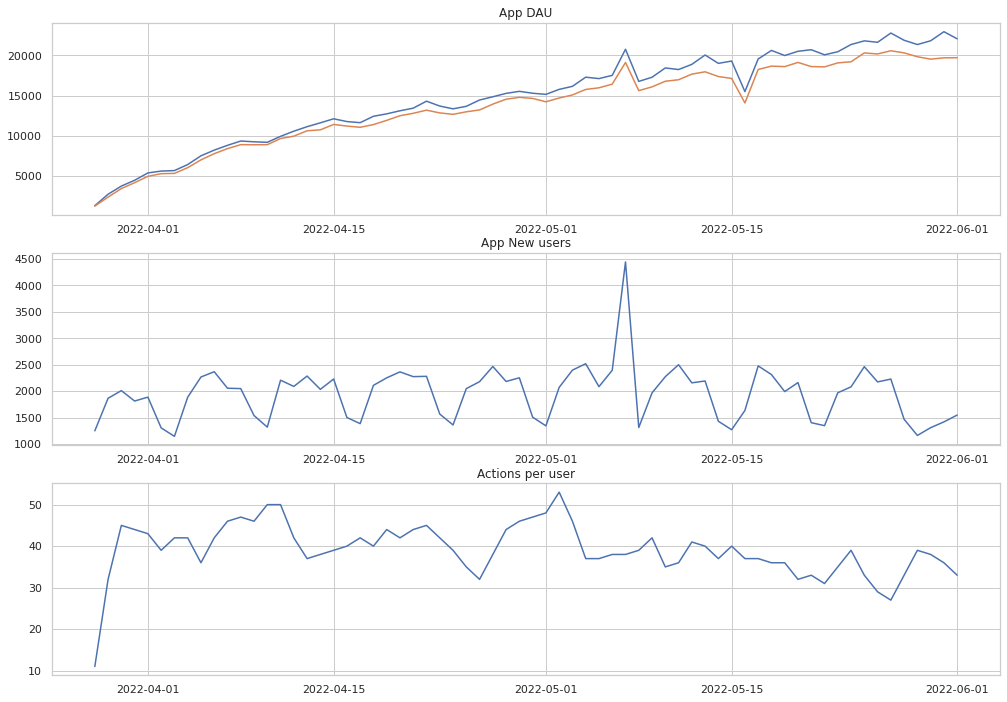

In [233]:
plt.figure(figsize=(17, 12))

plt.subplot (3, 1, 1)
sns.lineplot(data = full_data_new, x = 'day' , y = 'dau')
sns.lineplot(data = full_data_new, x = 'day' , y = 'user_id_news')
plt.title('App DAU')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('')

plt.subplot (3, 1, 2)
sns.lineplot(data = full_data_new, x = 'day' , y = 'new_user')
plt.title('App New users')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('')

plt.subplot (3, 1, 3)
sns.lineplot(data = full_data_new, x = 'day' , y = 'actions_per_user')
plt.title('Actions per user')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('')

In [234]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']

In [235]:
full_data_week = full_data_new[full_data_new.day >= week].reset_index()
full_data_week

,index,day,dau,new_user,new_user_organic,user_ads,like,view,message,user_id_news,...,user_id_news_message_new,user_id_only_news,user_id_only_message,CTR,actions_per_user,view_per_user,like_per_user,message_per_user,k-factor,ads_traffic
0,59,2022-05-26,21642,2176,982,8972,100663,522682,12901,20187.0,...,0,19980.0,1455.0,0.19,29.0,24.0,5.0,1.0,0.0504,0.41
1,60,2022-05-27,22796,2230,1031,9533,97989,502954,12899,20584.0,...,0,20256.0,2212.0,0.19,27.0,22.0,4.0,1.0,0.0501,0.42
2,61,2022-05-28,21894,1470,730,9144,123776,583300,12900,20322.0,...,0,20071.0,1572.0,0.21,33.0,27.0,6.0,1.0,0.0357,0.42
3,62,2022-05-29,21363,1165,507,8819,147098,682456,12900,19838.0,...,0,19627.0,1525.0,0.22,39.0,32.0,7.0,1.0,0.0251,0.41
4,63,2022-05-30,21832,1312,258,9177,145441,662836,12900,19540.0,...,0,19193.0,2292.0,0.22,38.0,30.0,7.0,1.0,0.0126,0.42
5,64,2022-05-31,22964,1421,207,10058,143682,660814,32259,19702.0,...,0,19217.0,3262.0,0.22,36.0,29.0,6.0,1.0,0.0096,0.44
6,65,2022-06-01,22076,1550,145,10004,120339,589754,12879,19717.0,...,0,19364.0,2359.0,0.20,33.0,27.0,5.0,1.0,0.0071,0.45


In [236]:
# Decide Colors 
mycolors = ['coral', 'c', 'darkgreen']

In [237]:
dau = full_data_week[['day','user_id_only_news','user_id_only_message','user_id_news_message']]
new_users = full_data_week[['day','user_id_only_news_new','user_id_only_message_new','user_id_news_message_new']]
actions = full_data_week[['day','view_per_user','like_per_user','message_per_user']]

In [240]:
actions

,day,view_per_user,like_per_user,message_per_user
0,2022-05-26,24.0,5.0,1.0
1,2022-05-27,22.0,4.0,1.0
2,2022-05-28,27.0,6.0,1.0
3,2022-05-29,32.0,7.0,1.0
4,2022-05-30,30.0,7.0,1.0
5,2022-05-31,29.0,6.0,1.0
6,2022-06-01,27.0,5.0,1.0


(19138.0, 19144.0)

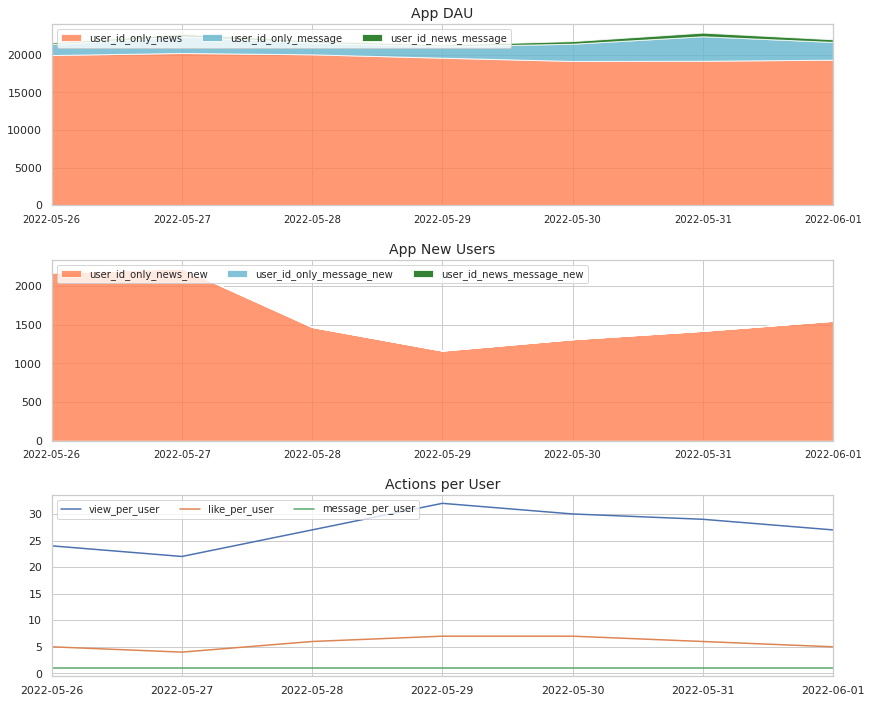

In [250]:
# Draw Plot and Annotate
#fig, ax = plt.subplots(1,1,figsize=(16, 7), dpi= 80)
plt.figure(figsize=(14, 12))

# ГРАФИК DAU
plt.subplot (3, 1, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
columns = dau.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = dau['day'].values
y0 = dau['user_id_only_news'].values.tolist()
y1 = dau['user_id_only_message'].values.tolist()
y2 = dau['user_id_news_message'].values.tolist()

y = np.vstack([y0, y1, y2])

# Plot for each column
ax = plt.gca()
ax.stackplot(x, y , labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('App DAU', fontsize=14)
#ax.set(ylim=[0, 30000])
ax.legend(fontsize=10, ncol=4,loc ='upper left')
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
#plt.yticks(np.arange(0, 30000, 5000), fontsize=10)
plt.xlim(x[0], x[-1])



# ГРАФИК НОВЫХ ПОЛЬЗОВАТЕЛЕЙ
plt.subplot (3, 1, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
columns = new_users.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = new_users['day'].values
y0 = new_users['user_id_only_news_new'].values.tolist()
y1 = new_users['user_id_only_message_new'].values.tolist()
y2 = new_users['user_id_news_message_new'].values.tolist()

y = np.vstack([y0, y1, y2])

# Plot for each column
ax = plt.gca()
ax.stackplot(x, y , labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('App New Users', fontsize=14)
#ax.set(ylim=[0, 3000])
ax.legend(fontsize=10, ncol=4,loc ='upper left')
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
#plt.yticks(np.arange(0, 3000, 500), fontsize=10)
plt.xlim(x[0], x[-1])

# график действий на одного пользователя
plt.subplot (3, 1, 3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax = plt.gca()
sns.lineplot(data = full_data_week, x = 'day' , y = 'view_per_user')
sns.lineplot(data = full_data_week, x = 'day' , y = 'like_per_user')
sns.lineplot(data = full_data_week, x = 'day' , y = 'message_per_user')
plt.legend(labels = ['view_per_user','like_per_user','message_per_user'],fontsize=10, ncol=4,loc ='upper left')
#ax.set(ylim=[0, 800000])
#plt.yticks(np.arange(0, 800000, 150000), fontsize=10)
plt.title('Actions per User', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('')
plt.xlim(x[0], x[-1])

In [221]:
text = '''
        Data report for {}: 
        App DAU                               {}
        News DAU                            {}
        Message DAU                       {} 
        News & Message DAU        {}
        App New Users                    {}
        Actions per user                  {}
        Ads_traffic                            {}
        Sticky Factor                         {}
        
        '''.format(yesterday,
                full_data_yesterday.dau[0],
                full_data_yesterday.user_id_news[0].astype(int),
                full_data_yesterday.user_id_message[0].astype(int),
                full_data_yesterday.user_id_news_message[0].astype(int),
                full_data_yesterday.new_user[0],
                full_data_yesterday.actions_per_user[0].astype(int),
                #full_data_yesterday['k-factor'][0],
                full_data_yesterday.ads_traffic[0],
                stickyfactor_yesterday.sticky_factor[0])

In [222]:
full_data_yesterday.user_id_news[0].astype(int)

19717

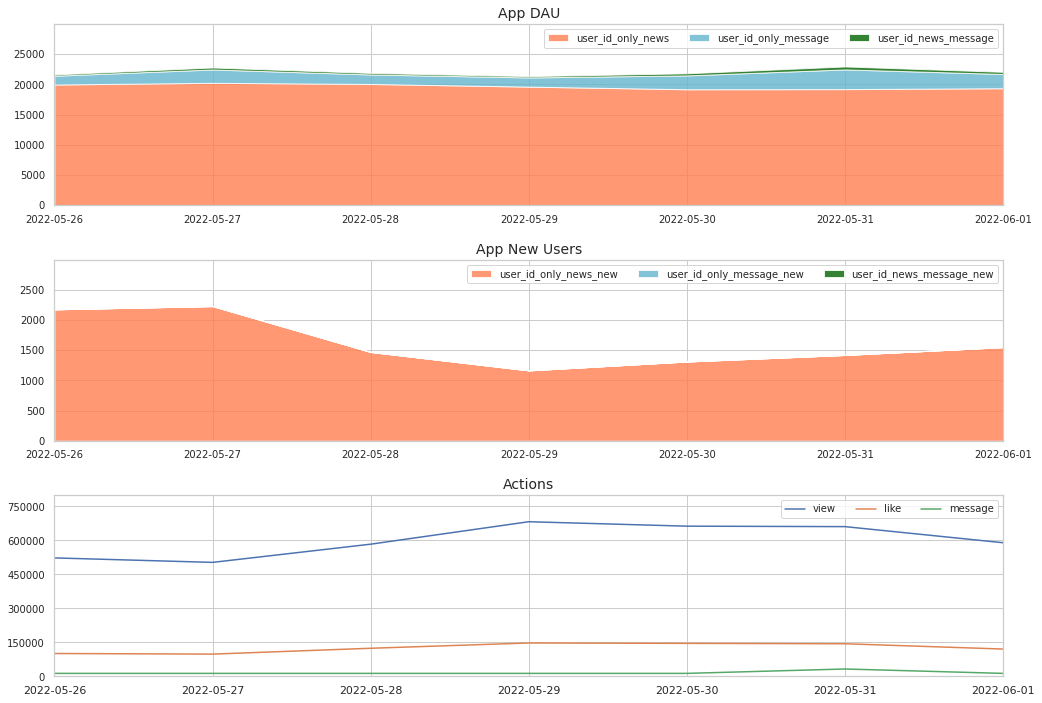

In [223]:
#подключаемся к телеге
chat_id = 400853280
token = '5368668226:AAGZNDxvxf83GApSiJqi5ahEkIHDXzV52Nw'
bot = telegram.Bot(token = token)
#гафики
# Draw Plot and Annotate
#fig, ax = plt.subplots(1,1,figsize=(16, 7), dpi= 80)
plt.figure(figsize=(17, 12))

# ГРАФИК DAU
plt.subplot (3, 1, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
columns = dau.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = dau['day'].values
y0 = dau['user_id_only_news'].values.tolist()
y1 = dau['user_id_only_message'].values.tolist()
y2 = dau['user_id_news_message'].values.tolist()

y = np.vstack([y0, y1, y2])

# Plot for each column
#labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y , labels=labs
             , colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('App DAU', fontsize=14)
ax.set(ylim=[0, 30000])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(0, 30000, 5000), fontsize=10)
plt.xlim(x[0], x[-1])



# ГРАФИК НОВЫХ ПОЛЬЗОВАТЕЛЕЙ
plt.subplot (3, 1, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
columns = new_users.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = new_users['day'].values
y0 = new_users['user_id_only_news_new'].values.tolist()
y1 = new_users['user_id_only_message_new'].values.tolist()
y2 = new_users['user_id_news_message_new'].values.tolist()

y = np.vstack([y0, y1, y2])

# Plot for each column
#labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y , labels=labs
             , colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('App New Users', fontsize=14)
ax.set(ylim=[0, 3000])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::1], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(0, 3000, 500), fontsize=10)
plt.xlim(x[0], x[-1])

plt.subplot (3, 1, 3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax = plt.gca()
sns.lineplot(data = full_data_week, x = 'day' , y = 'view')
sns.lineplot(data = full_data_week, x = 'day' , y = 'like')
sns.lineplot(data = full_data_week, x = 'day' , y = 'message')
plt.legend(labels = ['view','like','message'],fontsize=10, ncol=4,loc ='upper right')
ax.set(ylim=[0, 800000])
plt.yticks(np.arange(0, 800000, 150000), fontsize=10)
plt.title('Actions', fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('')
plt.xlim(x[0], x[-1])



#отправка графиков
plot_object = io.BytesIO()
plt.savefig(plot_object)
plot_object.name = 'plot.png'
#Перемещает указатель чтения/записи в файле.
plot_object.seek(0)
plt.close

bot.sendPhoto(chat_id = chat_id, photo = plot_object, caption = text)
